# Q1 - Traditional non neural network approach

- Pick an approach (such as Linear Regression) - classification method
- Why pick this approach? - 
- How well does this traditional approach work? - 

Aim at 'beginner ML audience'
Provide tutorial of method
Explain choices made

**Before working through this notebook, ensure you have read through the [README.md](https://github.com/GHancock1/Coursework-2/blob/main/README.md) and installed the necessary Python dependencies.**

In [ ]:
# Importing required libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import 


import sys
sys.path.append("..")
from functions import *

# Importing the Kepler Exoplanet Search Results dataset from GitHub.
df = getData()

# We don't need to know the intentity of every data type, so we will drop those columns.
df = df.drop(columns=["rowid","kepid", "kepoi_name", "kepler_name"])

To begin exploring how often an object confirmed to be an exoplanet in the literature is deconfirmed by Kepler data analysis, we should look at the data as-is in the dataset. To do so, we will use seaborn's pairplot function, with the points coloured by object's candidacy disposition

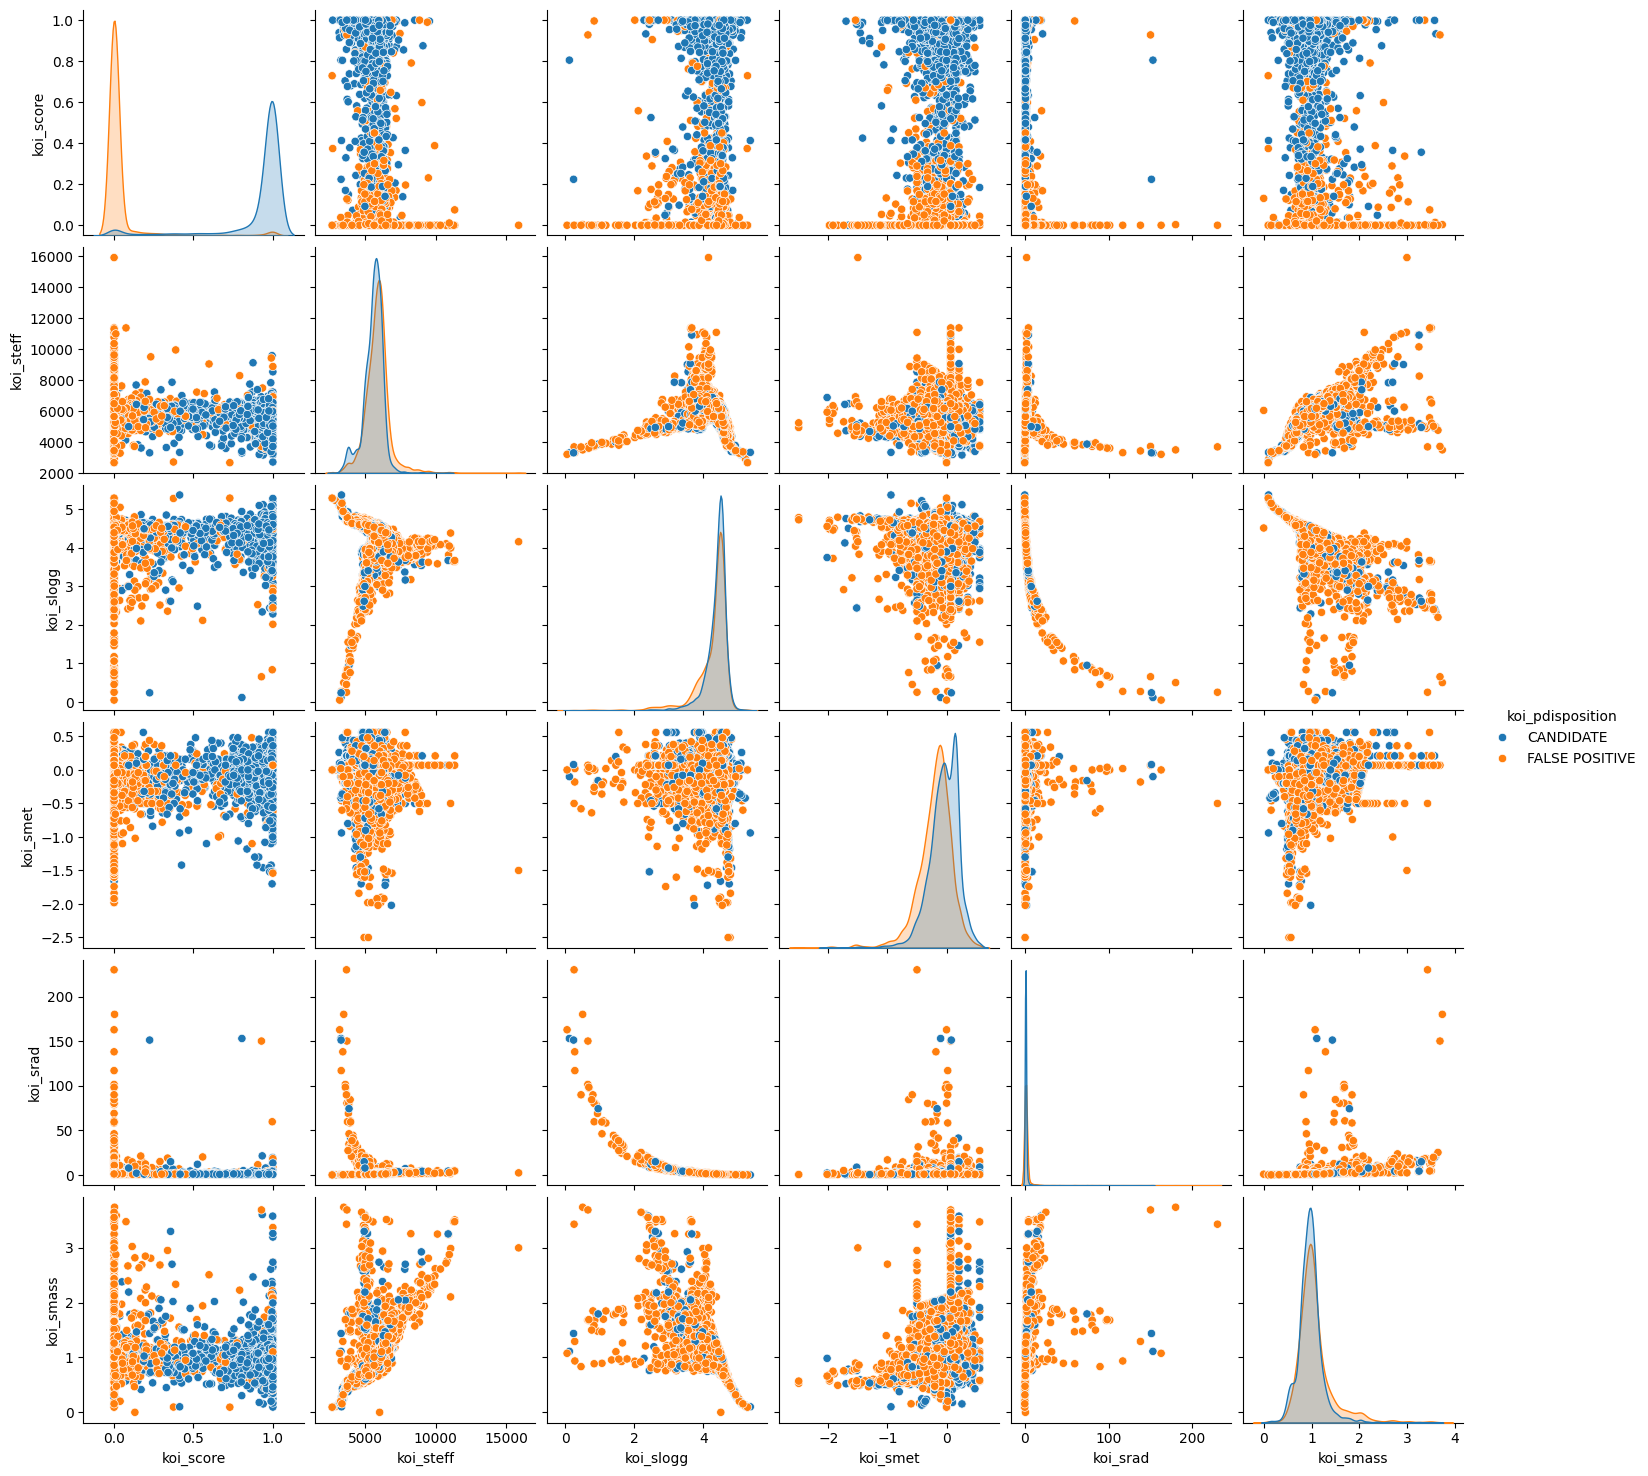

In [13]:

sns.pairplot(df, hue="koi_pdisposition")

From this cursory look, we can't initially see any patterns in the relationships between koi_score and stellar parameters. Perhaps if we normalize the data we will see some kind of pattern. To do so, we will use a technique called z-score normalization, or standardization. It transforms data into a normal distribution. The mathematics is as follows: 
$$
Z = \frac{X-\mu}{\sigma}
$$
Z is the z-score, X is the data point, $\mu$ is the mean, and $\sigma$ is the standard deviation.

In [25]:
scaled_df = normalize(df)
scaled_df.head()

,koi_disposition,koi_pdisposition,koi_score,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass
0,CONFIRMED,CANDIDATE,1.088571,-0.299933,0.347937,0.910978,-0.122480,-0.283167
1,CONFIRMED,CANDIDATE,1.023572,-0.299933,0.347937,0.910978,-0.122480,-0.283167
2,CANDIDATE,CANDIDATE,-1.008179,0.204968,0.529375,-0.235234,-0.131668,-0.159932
3,FALSE POSITIVE,FALSE POSITIVE,-1.008179,0.144075,0.576501,-1.453084,-0.143658,-0.526704
4,CONFIRMED,CANDIDATE,1.088571,0.430778,0.279603,0.660244,-0.103950,0.233249


The standard in machine learning is to have the features (columns) of the data labelled **X**, and the target (what you want to compare features to) labelled y.

In [27]:
X = scaled_df.filter(["koi_steff", "koi_slogg", "koi_smet", "koi_srad", "koi_smass"])
y = scaled_df["koi_score"]

Some rows are missing koi_score. This could cause issues, so we will drop those rows.

In [ ]:
# Dropping rows with any missing values/
X = X.dropna()
y = y.dropna()

# Ensuring y lines up to X.
y = y.loc[X.index]

In [34]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=3, include_bias=False)
poly_X = poly.fit_transform(X)
model = LinearRegression()
model.fit(poly_X, y)

y_pred = model.predict(poly_X)

ValueError: Input X contains NaN.
PolynomialFeatures does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values